# Completion time for IC students at EPFL

For this exercise, the goal was to study how much time students at the IC department at EPFL. The data are collected by using the open data from ISAcademia's [List of registered students by section and semester](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247)

The study was completed in the following steps:
    
1. Fetch all the data from ISAcademia\n",
1. Get the data into Pandas dataframe\n",
1. Split the data into to partions: bachelor and master studies\n",
1. Calculate the completion time for each student\n",
1. Calculate the mean completion time for men and female on the different groups\n",
1. Do statistical tests and visualization on the results\n"

## Fetching the data from the IS Academia API

We start by getting the HTML response of the tabular student data from ISAcademia.
For this, we use the [Requests](http://docs.python-requests.org/en/master/) library.


In [1]:
# Import the libraries we need

%run imports.py
%matplotlib inline

## Making the reqest

*Warning*: we are loading a lot of data, thus the loading takes quite a long time. Therefore, don't run this unless it's needed

To not spam the API too much, we collect all the data in one try, and filter it afterwords.

We use the following parameters:

~~~~~~~~~~~~~~~~
- ww_x_GPS:-1
- ww_i_reportModel:133685247
- ww_i_reportModelXsl:133685270
- ww_x_UNITE_ACAD:249847
- ww_x_PERIODE_ACAD:null
- ww_x_PERIODE_PEDAGO:null
- ww_x_HIVERETE:null
~~~~~~~~~~~~~~~~

Which leads to the following request:
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=null&ww_x_PERIODE_PEDAGO=null&ww_x_HIVERETE=null

We are now fetching data for all Computer Science students (Informatique) for all available years and semesters.
Such querring technique might be problematic with larger datasets (would probably result in server timeout) but since it works for our problem we stick to it.


In [2]:
# For 'production', collect all the data available from ISAcademia, for students at the IC-section
uri = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=null&ww_x_PERIODE_PEDAGO=null&ww_x_HIVERETE=null"

req = requests.get(uri)

## Parsing the result

In [3]:
# Defining some helper functions, for clarity
def clean(string):
    return string.strip().lower().replace(' ', '_')

def is_semester_info(data):
    return len(data) <= 2

def is_header(data):
    return not ((len(data) > 2) and data[-2].isdigit())

# The parse_table takes the html table as input, and returns a table of the students
def parse_table(table):
    students = []
    header = ''
    semester = ''

    for tr in table:
        row_data = []
        for td in tr:
            value = td.get_text().strip().replace('\xa0', ' ')
            row_data.append(value)

                     
        if is_semester_info(row_data):
            info = [clean(value) for value in row_data[0].split(', ')]
            section = info[0]
            year = info[1]
            semester, _ = info[2].split('\n_')
        elif(is_header(row_data)):
            header = [ clean(val) for val  in  row_data] 
        else:
            person = {'year': year, 'semester': semester, 'section': section}
            for i, key in enumerate(header):
                val = row_data[i].strip()
                if val: 
                    person[key] = val
                    
            students.append(person)
    
    return students

In [4]:
soup = BeautifulSoup(req.text, 'html.parser')
students_html = soup.find('table')

students_list = parse_table(students_html)

In [5]:
# Put the students into a Pandas dataframe
students = pd.DataFrame(students_list)

# Lets list some basic info about parsed data
print(students.shape)
print(students.dtypes)
students.head()

(20107, 12)
civilité          object
ecole_echange     object
filière_opt.      object
mineur            object
no_sciper         object
nom_prénom        object
section           object
semester          object
spécialisation    object
statut            object
type_echange      object
year              object
dtype: object


,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year
0,Monsieur,Universidad de Granada,NaN,NaN,170337,Arco Arredondo Rafael,echange_in,semestre_automne,NaN,Présent,Erasmus,2005-2006
1,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171585,Balas Marc,echange_in,semestre_automne,NaN,Présent,Erasmus,2005-2006
2,Madame,Linköping University,NaN,NaN,170200,Bergendal Anna,echange_in,semestre_automne,NaN,Présent,Erasmus,2005-2006
3,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171880,Bret Jean-Sébastien,echange_in,semestre_automne,NaN,Présent,Erasmus,2005-2006
4,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171505,Burret Nicolas,echange_in,semestre_automne,NaN,Présent,Erasmus,2005-2006


In [6]:
# First of all we noticed that parsing all data without specifing date 
# also resulted in data of students from years before 2007 and we don't want that.

# Lets split year column into year_start and year_end
students['year_start'], students['year_end'] = students['year'].str.split('-', 1).str
# Cast from object to int
students[['year_start','year_end']] = students[['year_start','year_end']].apply(pd.to_numeric)
# Drop year column 
del students['year']

# Verify
print(students.dtypes)
students.head()


civilité          object
ecole_echange     object
filière_opt.      object
mineur            object
no_sciper         object
nom_prénom        object
section           object
semester          object
spécialisation    object
statut            object
type_echange      object
year_start         int64
year_end           int64
dtype: object


,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
0,Monsieur,Universidad de Granada,NaN,NaN,170337,Arco Arredondo Rafael,echange_in,semestre_automne,NaN,Présent,Erasmus,2005,2006
1,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171585,Balas Marc,echange_in,semestre_automne,NaN,Présent,Erasmus,2005,2006
2,Madame,Linköping University,NaN,NaN,170200,Bergendal Anna,echange_in,semestre_automne,NaN,Présent,Erasmus,2005,2006
3,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171880,Bret Jean-Sébastien,echange_in,semestre_automne,NaN,Présent,Erasmus,2005,2006
4,Monsieur,Ecole Supérieure de Chimie Physique Electroniq...,NaN,NaN,171505,Burret Nicolas,echange_in,semestre_automne,NaN,Présent,Erasmus,2005,2006


# Bachelor students

In [7]:
bachelor_df = students[students["semester"].str.contains("bachelor_semestre")]
print(bachelor_df.shape)
bachelor_df.head()

(7271, 13)


,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
8740,Monsieur,NaN,NaN,NaN,154168,Aghamahdi Mohammad Hossein,informatique,bachelor_semestre_1,NaN,Présent,NaN,2004,2005
8741,Monsieur,NaN,NaN,NaN,160104,Alves Sergio,informatique,bachelor_semestre_1,NaN,Présent,NaN,2004,2005
8742,Madame,NaN,NaN,NaN,154157,Andriambololona Riana Miarantsoa,informatique,bachelor_semestre_1,NaN,Présent,NaN,2004,2005
8743,Monsieur,NaN,NaN,NaN,166876,Aslan Unal,informatique,bachelor_semestre_1,NaN,Présent,NaN,2004,2005
8744,Monsieur,NaN,NaN,NaN,166258,Balet Ken,informatique,bachelor_semestre_1,NaN,Présent,NaN,2004,2005


In [8]:
# ...from year 2007 and above
bachelor_from_2007_df = bachelor_df[bachelor_df["year_start"] >= 2007]
print(bachelor_from_2007_df.shape)
bachelor_from_2007_df.head()

(5807, 13)


,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
11056,Monsieur,NaN,NaN,NaN,169569,Arévalo Christian,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11057,Monsieur,NaN,NaN,NaN,174905,Aubelle Flavien,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11058,Monsieur,NaN,NaN,NaN,173922,Badoud Morgan,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11059,Monsieur,NaN,NaN,NaN,179406,Baeriswyl Jonathan,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11060,Monsieur,NaN,NaN,NaN,179428,Barroco Michael,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008


## Extract bachelor candidates based on their semester entries
Search for students(rows) who either have bachelor_semestre_1 or bachelor_semestre_6

Only consider students that were in Semester 1 and have done their Master project. This data set includes Minors. Since Minors and Specializations are allowed to have a semester longer. Technically these would need to be excluded to measure the pure length of an IC Master. For the Minors this would be possible but for the Specializations there is no way to evalute it, hence we use the combined dataset to compensate for that fact.

In [9]:
pruned_bachelor = bachelor_from_2007_df.groupby(['nom_prénom']).filter(lambda x: x['semester'].str.contains('bachelor_semestre_1').any() and x['semester'].str.contains('bachelor_semestre_6').any())
pruned_bachelor = pruned_bachelor.groupby(['nom_prénom'])
pruned_bachelor.head(10)

,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
11056,Monsieur,NaN,NaN,NaN,169569,Arévalo Christian,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11057,Monsieur,NaN,NaN,NaN,174905,Aubelle Flavien,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11059,Monsieur,NaN,NaN,NaN,179406,Baeriswyl Jonathan,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11060,Monsieur,NaN,NaN,NaN,179428,Barroco Michael,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11063,Monsieur,NaN,NaN,NaN,179449,Bindschaedler Vincent,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11064,Monsieur,NaN,NaN,NaN,178553,Bloch Marc-Olivier,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11065,Monsieur,NaN,NaN,NaN,179426,Bloch Remi,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11066,Monsieur,NaN,NaN,NaN,178271,Boéchat Marc-Alexandre,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11068,Monsieur,NaN,NaN,NaN,180731,Bricola Jean-Charles,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008
11069,Monsieur,NaN,NaN,NaN,171619,Buchschacher Nicolas,informatique,bachelor_semestre_1,NaN,Présent,NaN,2007,2008


Calculate the number of semesters by counting the rows in each group. Then convert the collected GroupBy data to a DataFrame and add the gender column.

In [10]:
def is_men(row):
    if row['civilité'] == 'Monsieur':
        val = 1
    else:
        val = 0
    return val

bachelor_total = pd.DataFrame(pruned_bachelor.size().rename('total_semester_count'))
bachelor_total['civilité'] = bachelor_total.index.map(lambda x: bachelor_df[bachelor_df['nom_prénom'] == str(x)].civilité.unique()[0])
bachelor_total['gender'] = bachelor_total.apply(is_men, axis=1)
bachelor_total.head(10)

,total_semester_count,civilité,gender
nom_prénom,,,
Abate Bryan Jeremy,6,Monsieur,1
Aiulfi Loris Sandro,12,Monsieur,1
Alami-Idrissi Ali,6,Monsieur,1
Alfonso Peterssen Alfonso,6,Monsieur,1
Alonso Seisdedos Florian,11,Monsieur,1
Amorim Afonso Caldeira Da Silva Pedro Maria,8,Monsieur,1
Andreina Sébastien Laurent,8,Monsieur,1
Angel Axel,6,Monsieur,1
Angerand Grégoire Georges Jacques,10,Monsieur,1


## Dealing with extreme values

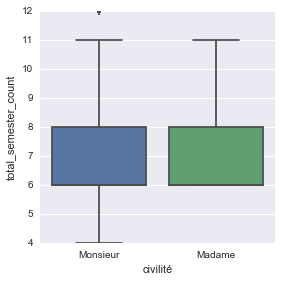

In [11]:
box = sns.factorplot(x='civilité', y='total_semester_count', data=bachelor_total, kind="box")

In [12]:
# We see that there are some strange case where someone has completed in less than 6 semesters. 

bachelor_total.sort_values("total_semester_count")
bachelor_from_2007_df[bachelor_from_2007_df.nom_prénom == "Séguy Louis Marie James"]

,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
13729,Monsieur,NaN,NaN,NaN,204222,Séguy Louis Marie James,informatique,bachelor_semestre_1,NaN,Présent,NaN,2011,2012
13854,Monsieur,NaN,NaN,NaN,204222,Séguy Louis Marie James,informatique,bachelor_semestre_2,NaN,Présent,NaN,2011,2012
17278,Monsieur,NaN,NaN,NaN,204222,Séguy Louis Marie James,informatique,bachelor_semestre_5,NaN,Présent,NaN,2014,2015
17397,Monsieur,NaN,NaN,NaN,204222,Séguy Louis Marie James,informatique,bachelor_semestre_6,NaN,Présent,NaN,2014,2015


In [13]:
# As he has been away in the middle his bachelor, he seems to not be registerd in 2013/2014 and 2014/2015
# This is a special case, so we drop him from our calculations

bachelor_total.drop("Séguy Louis Marie James", inplace=True)

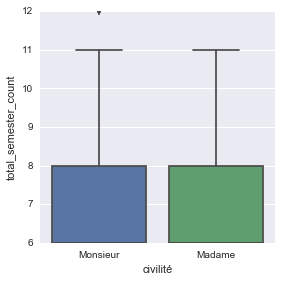

In [14]:
# Now the plot looks more reasonable

box = sns.factorplot(x='civilité', y='total_semester_count', data=bachelor_total, kind="box")

In [15]:
# We allso explored the outliers that are present in the the boxplot
bachelor_total.sort_values("total_semester_count", ascending=False).head(10)


,total_semester_count,civilité,gender
nom_prénom,,,
Habegger Loïc,12,Monsieur,1
Aiulfi Loris Sandro,12,Monsieur,1
Lukas Loris,12,Monsieur,1
Jolidon Fabien,12,Monsieur,1
Heer Philippe,12,Monsieur,1
Fol Charles,12,Monsieur,1
Garret Louis-Maxence Thierry Clément Marie,11,Monsieur,1
Grondier Julien François Nizar,11,Monsieur,1
Goullet Boris Melvil,11,Monsieur,1


In [16]:
# Lets study the top example
bachelor_from_2007_df[bachelor_from_2007_df.nom_prénom == "Habegger Loïc"]

# From this table it seems like he actually completed in 12 semsetres. Therefore, we descide
# Not to do more about the rest of the outliers

,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
12248,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_1,NaN,Présent,NaN,2009,2010
12359,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_2,NaN,Présent,NaN,2009,2010
12899,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_1,NaN,Présent,NaN,2010,2011
13043,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_2,NaN,Présent,NaN,2010,2011
13910,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_3,NaN,Présent,NaN,2011,2012
13986,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_4,NaN,Présent,NaN,2011,2012
15020,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_5,NaN,Présent,NaN,2012,2013
15111,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_6,NaN,Présent,NaN,2012,2013
16111,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_5,NaN,Présent,NaN,2013,2014
16202,Monsieur,NaN,NaN,NaN,195804,Habegger Loïc,informatique,bachelor_semestre_6,NaN,Présent,NaN,2013,2014


## Results

In [17]:
# Calculate the distribution of men and women in our data set
# Notice the big number of males(92.67%) over females(8.33%)

bachelor_total["gender"].mean()

0.9267676767676768

In [18]:
bachelor_total.groupby(['civilité'])['total_semester_count'].mean()

# But it appears that females are better students! On avarage they take less time to complete bachelor.

civilité
Madame      6.793103
Monsieur    7.114441
Name: total_semester_count, dtype: float64

In [19]:

men_df = bachelor_total[bachelor_total["gender"] == 1]
women_df = bachelor_total[bachelor_total["gender"] == 0]

stats.ttest_ind(men_df.total_semester_count, women_df.total_semester_count)

Ttest_indResult(statistic=1.0973953830571002, pvalue=0.27313881056990413)

In a two-sample test, the null hypothesis is that the means of both groups are the same, e.g. that 
men and women take on avarage the same time to complete studies. Our average says differentely but that's probably because women data set is to small and not statistically significant. 

The test yields a p-value of 0.22800520488780102, which means there is a 22.8% chance we'd see sample data 
this far apart if the two groups tested are actually identical. If we were using a 95% confidence level we 
would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance 
level of 5%.

# Masters

Initially prune Master dataset to only contain data after year 2007

In [20]:
master_copy = students.copy()
master_df = master_copy[master_copy['year_start'] >= 2007]
master_df = master_df[master_df.semester.str.contains('master')]

master_df.semester.value_counts()

master_semestre_2          1062
master_semestre_1           948
master_semestre_3           706
projet_master_automne        86
projet_master_printemps      42
Name: semester, dtype: int64

Creation of needed master DataFrames for semester 1/2/3 and Master Project

### Calculate number of month for master

In [21]:
students[students['nom_prénom']=='Brutsche Florian'].civilité.unique()[0]
master_df[master_df['nom_prénom'] == 'Brutsche Florian']

,civilité,ecole_echange,filière_opt.,mineur,no_sciper,nom_prénom,section,semester,spécialisation,statut,type_echange,year_start,year_end
11563,Monsieur,NaN,NaN,NaN,159852,Brutsche Florian,informatique,master_semestre_3,Internet computing,Présent,NaN,2007,2008
11626,Monsieur,NaN,NaN,NaN,159852,Brutsche Florian,informatique,projet_master_printemps,Internet computing,Congé,NaN,2007,2008
12190,Monsieur,NaN,NaN,NaN,159852,Brutsche Florian,informatique,projet_master_automne,Internet computing,Congé,NaN,2008,2009


Only consider students that were in Semester 1 and have done their Master project. This data set includes Minors. Since Minors and Specializations are allowed to have a semester longer. Technically these would need to be excluded to measure the pure length of an IC Master. For the Minors this would be possible but for the Specializations there is no way to evalute it, hence we use the combined dataset to compensate for that fact.

In [22]:
pruned_master = master_df.groupby(['nom_prénom']).filter(lambda x: x['semester'].str.contains('projet_master').any() and x['semester'].str.contains('semestre_1').any())
pruned_master = pruned_master.groupby(['nom_prénom'])

master_total = pd.DataFrame(pruned_master.size().rename('total_semester_count'))
master_total['civilité'] = master_total.index.map(lambda x: master_df[master_df['nom_prénom'] == str(x)].civilité.unique()[0])

master_total['gender'] = master_total.apply(is_men, axis=1)
master_total.head(20)

,total_semester_count,civilité,gender
nom_prénom,,,
Agarwal Megha,3,Madame,0
Amiguet Jérôme,5,Monsieur,1
Antognini Diego Matteo,3,Monsieur,1
Antognini Marco,7,Monsieur,1
Atitallah Samir,3,Monsieur,1
Aydin Ebru,3,Madame,0
Benabdallah Zeineb,6,Madame,0
Billaud Joël,4,Monsieur,1
Biollay Jean Isaac Jamal Pachacutec,4,Monsieur,1


## Results

In the boxplot underneath, we abserve that the mean values between men and women are pretty much the same, while the variance is much higher for men.

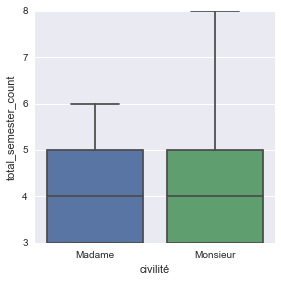

In [23]:
box = sns.factorplot(x='civilité', y='total_semester_count', data=master_total, kind="box")

In [24]:
master_total['gender'].mean()

0.8859649122807017

Again we are dealing with ~88.60% of males and ~11.40% of females...

In [25]:
master_total.groupby(['civilité'])['total_semester_count'].mean()

civilité
Madame      4.153846
Monsieur    4.277228
Name: total_semester_count, dtype: float64

...and it appears that on avarage it takes more time for males to complete master degree:
1. Males - 4.27 semesters = 25.62 months = over 2 years
2. Females - 4.15 semesters = 24.9 months = just slightly over 2 years

In a two-sample test, the null hypothesis is that the means of both groups are the same - men and women take on avarage the same time to complete studies. Our average says differentely but that's because probably women data set is to small and not statistically significant. 

In [26]:
master_men_df = master_total[master_total['gender']==1]
master_women_df = master_total[master_total['gender']==0]

stats.ttest_ind(master_men_df.total_semester_count, master_women_df.total_semester_count)

Ttest_indResult(statistic=0.39806237735379474, pvalue=0.69134195843335622)

The test yields a **p-value = 0.6913**, which means there is a 69.13% chance we'd see sample data this far apart if the two groups tested are actually identical. If we were using a 95% confidence level we would **fail to reject the null hypothesis**, since the p-value is greater than the corresponding significance level of 5%.
**We definetely cannot write a paper based on such results.** 